In [1]:
#Import important library 
import numpy as np
import os
import sys
import arviz as az

from scipy.sparse import coo_matrix, csr_matrix
from scipy.stats import gmean
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

sys.path.append('.')

# Internal inmport

from src.models.RapidCRMclass import *
from src.models.GraphModelclass import *

from src.utils.AuxiliaryFunc import *
from src.utils.CootoNetworkX import *
from src.utils.ConvertArviZ import *

from src.inference.GraphMCMCclass import * 
from src.inference.Graphmcmcsamples import *

from src.utils.SaveData import *
from src.utils.pSampling import *

from src.display.plotposteriorpredictivedegreedistrib import plot_posterior_predictive_degree
from src.display.plot_mean_w_ci import plot_mean_w_ci

In this notebook we demonstrate how to use our methods on real world data. Here we use the Douban data, and we subsampling a very small graph to keep the experiment short. 

# Extraction of the Douban subgraph

In [2]:
def read_graph_to_coo(file_path):
    # Read the file and extract the edges
    with open(file_path, 'r') as f:
        edges = [tuple(map(int, line.split())) for line in f]
    # Extracting rows (source nodes) and columns (target nodes) from edges
    row = np.array([edge[0]-1 for edge in edges])
    maxrow=np.max(row)
    col = np.array([edge[1]-1 for edge in edges])
    maxcol=np.max(col)
    maxtot=np.max((maxrow,maxcol))
    # Data array (for a simple adjacency matrix, all edges have a weight of 1)
    data = np.ones(len(edges), dtype=int)
    # Create a COO matrix
    adj_matrix = coo_matrix((data, (row, col)),shape=(maxtot+1,maxtot+1))
    
    return adj_matrix

adj_matrix = read_graph_to_coo('../data/Douban.txt')
G0=adj_matrix+adj_matrix.T
G0.data[:]=1
n=G0.shape[0]

p=0.05
G,notG=pSampling(G0.tocoo(),p)
G=G.tocoo()


In [3]:
# Graph description 
print('Nb of nodes:', G.shape[0])
print('Nb of edges:', G.nnz)

Nb of nodes: 1014
Nb of edges: 1676


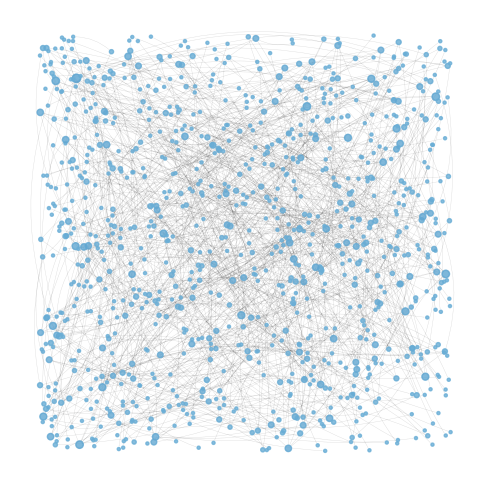

In [4]:
#Graph plot
# Node positions using spring layout
Gnx = coo_to_networkx(G)
pos = nx.random_layout(Gnx, seed=42)

# Node degrees for size scaling
degrees = np.array([Gnx.degree(n) for n in Gnx.nodes()])
node_sizes = 1+4*degrees  # Scale node size by degree

# Colour nodes based on degree
# Colour nodes: darker for higher degree
# Colour nodes: darker shades of blue for higher degree
cmap = plt.colormaps["Blues"]
norm = mcolors.Normalize(vmin=1, vmax=100)
node_colors = [cmap(0.5+0.7*norm(deg)) for deg in degrees]


# Draw the graph
plt.figure(figsize=(6, 6))
nx.draw_networkx_nodes(Gnx, pos, node_size=node_sizes,node_color=node_colors, alpha=0.8)
# Draw curved edges
for edge in Gnx.edges():
    node1, node2 = edge
    rad = 0.2  # Controls the curvature
    edge_patch = mpatches.FancyArrowPatch(
        pos[node1], pos[node2],
        connectionstyle=f"arc3,rad={rad}",
        color="black", alpha=0.1, lw=0.1
    )
    plt.gca().add_patch(edge_patch)
# Show the plot
plt.axis("off")
plt.show()

# Inference on Real World Data

In [5]:
# Choose prior
alpha=1
tau=0.
hyper_beta = [0.01, 0.01]  # Improper prior on beta
hyper_c = [20, 0.5] 
hyper_eta = [0.1, 0.1] # Improper prior on eta
objprior = GraphModel('Rapid',alpha,tau, hyper_beta, hyper_c, hyper_eta)


# Parametter of the  MCMC Algorithm
niter = 100000
nburn = 0
nadapt = niter//2
thin = niter//1000
nchains = 2

objmcmc = GraphMCMC(objprior, niter, nburn, thin, nadapt, nchains, store_w=True)
objmcmc.settings["hyper"]={'rw_std': np.array([0.01,0.01,0.02]), 'MH_nb': 1}

optional_arg = defaultdict(lambda: None)
optional_arg["decoupling"]=True
optional_arg['nmass']=100

true_value = defaultdict(lambda: None)

In [6]:
graphmcmcsamples(objmcmc,G,optional_arg,true_value,output_dir="output_dir",verbose=False)

[os.remove(f"{d}/{f}") for d, _, fs in os.walk("output_dir", False) for f in fs]
[os.rmdir(d) for d, ds, _ in os.walk("output_dir", False)]


100%|██████████| 100000/100000 [01:01<00:00, 1631.66it/s]


-------------------------------
End MCMC for RapidCRM graphs
-------------------------------


100%|██████████| 100000/100000 [01:01<00:00, 1614.36it/s]


-------------------------------
End MCMC for RapidCRM graphs
-------------------------------


[None, None]

# Visualisation of the inference procedure

We then display the trace plots, credibility intervals, posterior predictive of the degree distribution and convergence diagnostics. 

## Trace plots of the hyperparameters  

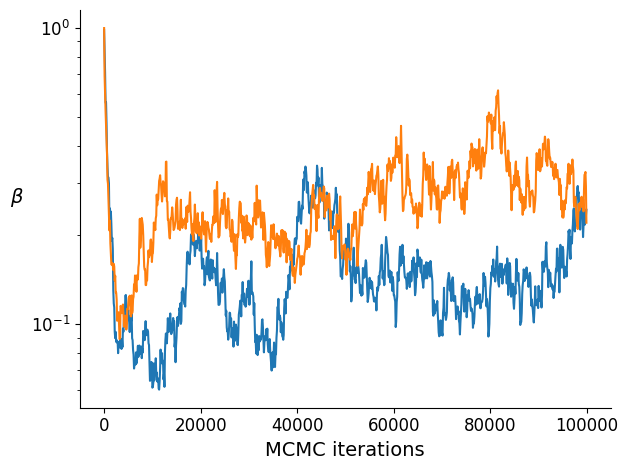

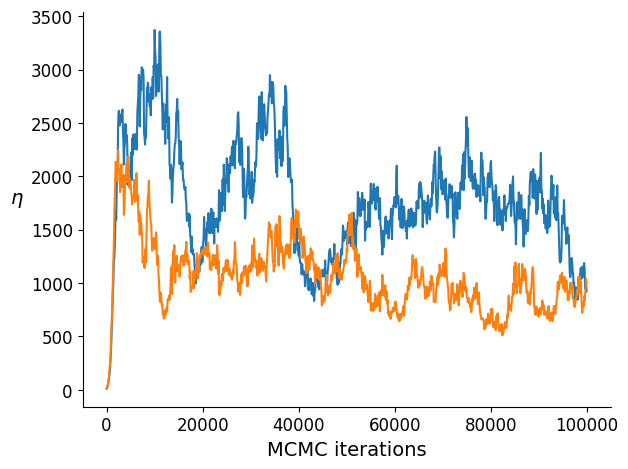

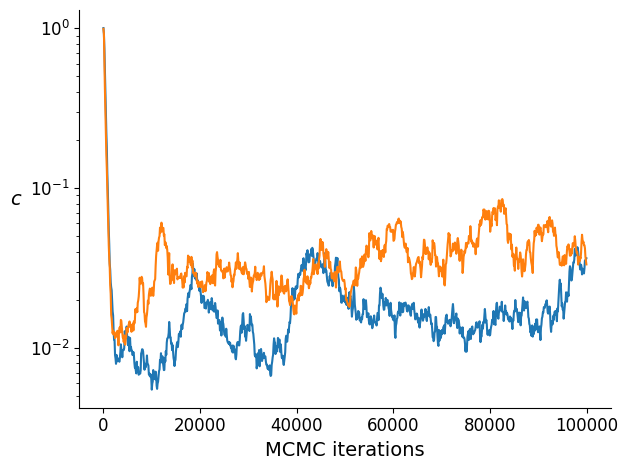

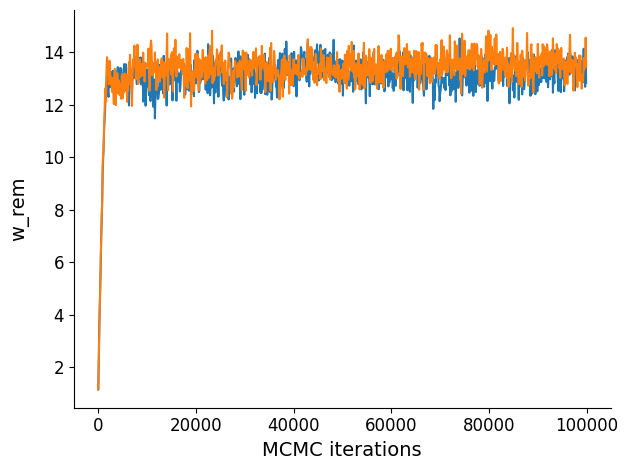

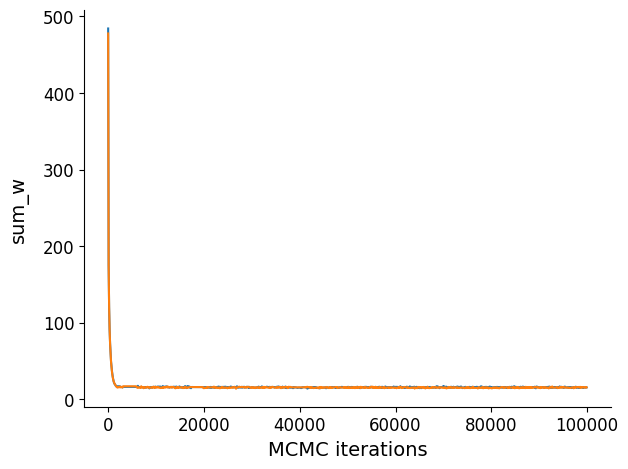

In [13]:
X=np.arange(0,niter,thin)

plt.figure(dpi=100)
for i in range(nchains):
    plt.plot(X, objmcmc.samples[i]["beta"])
plt.yscale('log')
plt.ylabel(r'$\beta$', fontsize=14, rotation=0, labelpad=10)
plt.xlabel('MCMC iterations', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()


plt.figure(dpi=100)
for i in range(nchains):
    plt.plot(X, objmcmc.samples[i]["eta"])
plt.ylabel(r'$\eta$', fontsize=14, rotation=0, labelpad=10)
plt.xlabel('MCMC iterations', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

plt.figure(dpi=100)
for i in range(nchains):
    plt.plot(X, objmcmc.samples[i]["c"])
plt.yscale('log')
plt.ylabel(r'$c$', fontsize=14, rotation=0, labelpad=10)
plt.xlabel('MCMC iterations', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()


plt.figure(dpi=100)
for i in range(nchains):
    plt.plot(X, objmcmc.samples[i]["w_rem"])
plt.ylabel(r'w_rem', fontsize=14, rotation=90, labelpad=10)
plt.xlabel('MCMC iterations', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

plt.figure(dpi=100)
for i in range(nchains):
    plt.plot(X,np.sum(objmcmc.samples[i]["w"], axis=1))
plt.ylabel(r'sum_w', fontsize=14, rotation=90, labelpad=10)
plt.xlabel('MCMC iterations', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

## Trace plots of some weights

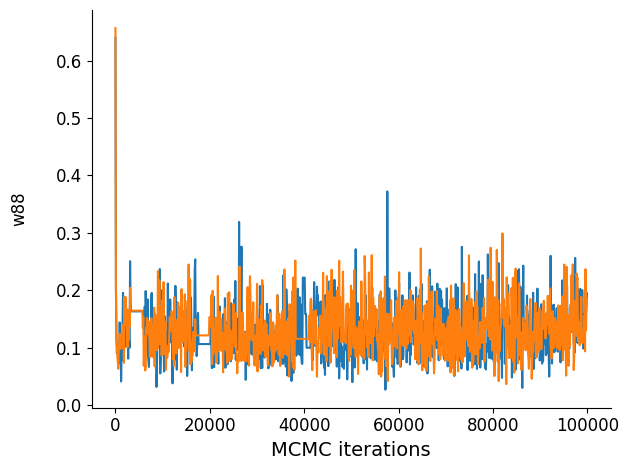

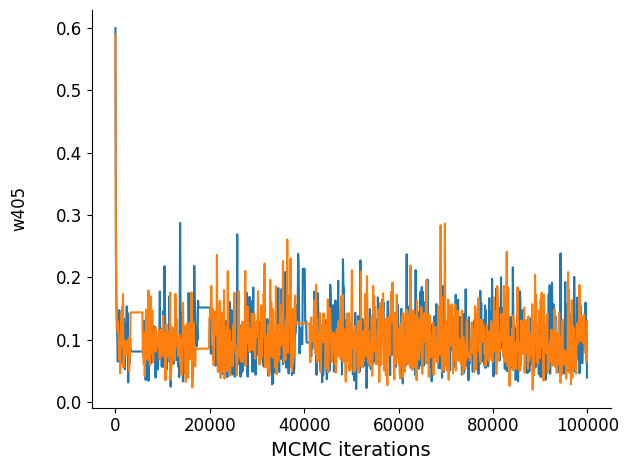

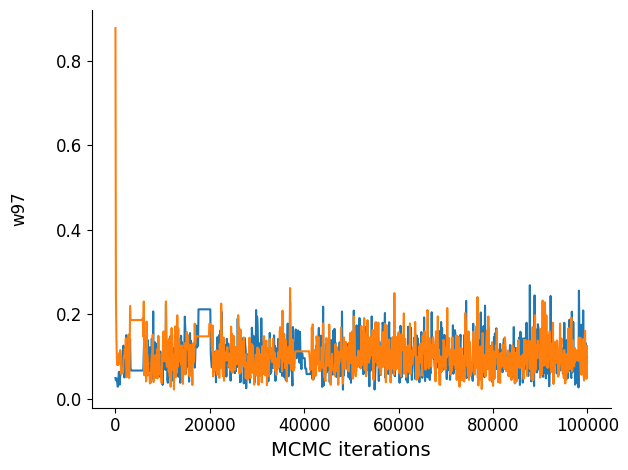

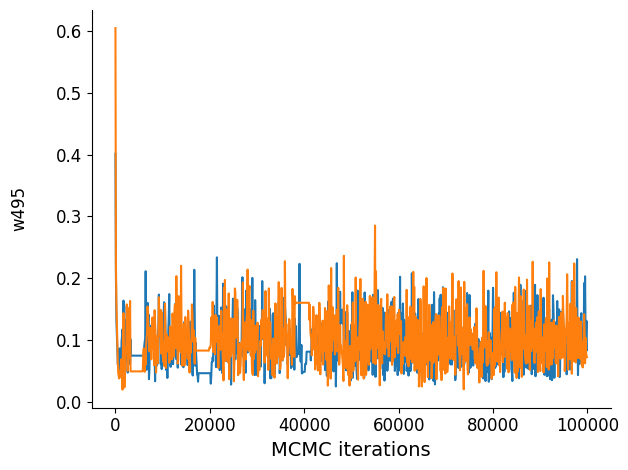

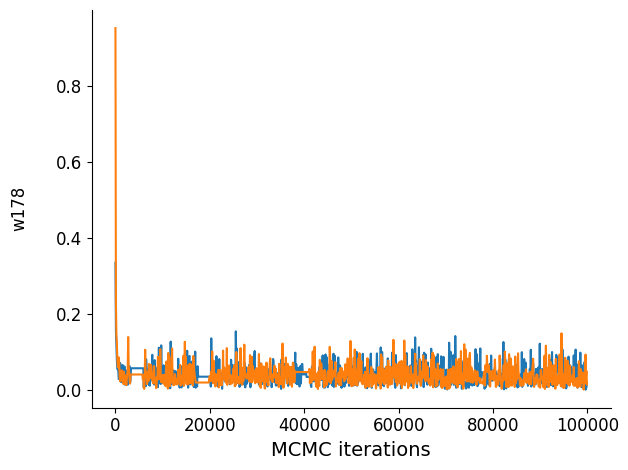

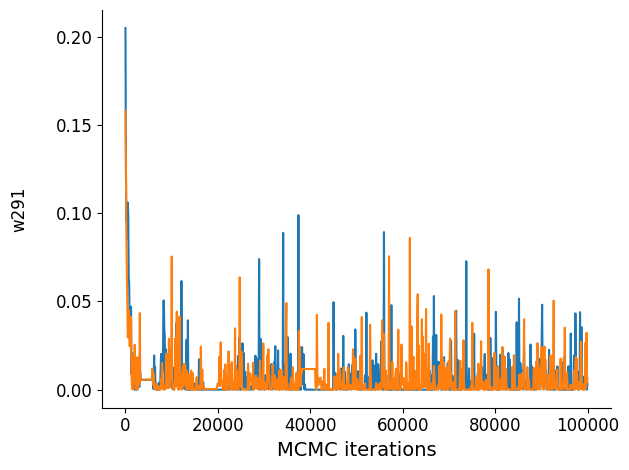

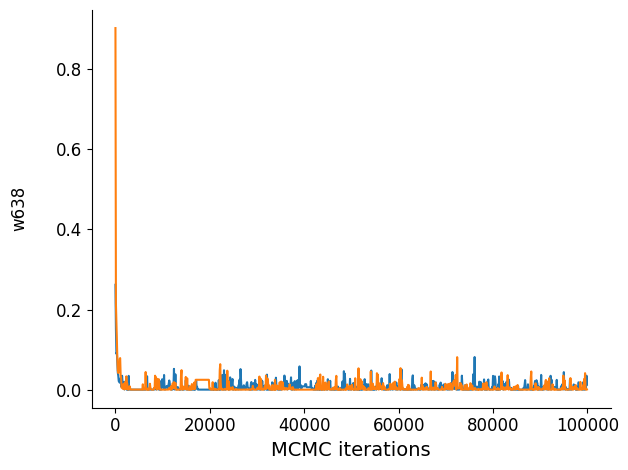

In [8]:
#We order th weights by degree
ind= np.array(np.argsort(np.sum(G, axis=0)))
ind=ind[0][::-1]


niter
# Plot largest weights
for i in range(4):
    plt.figure(dpi=100)
    for j in range(nchains):
        plt.plot(X, objmcmc.samples[j]["w"][:, ind[i]])
    plt.ylabel(f'w{str(ind[i])}', fontsize=12, rotation=90, labelpad=20)
    plt.xlabel('MCMC iterations', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    plt.show()
    
# Plot some small weights
ind2 = [100, 500, 1000]
for i in ind2:
    plt.figure(dpi=100)
    for j in range(nchains):
        plt.plot(X, objmcmc.samples[j]["w"][:, ind[i]])
    plt.ylabel(f'w{str(ind[i])}', fontsize=12, rotation=90, labelpad=20)
    plt.xlabel('MCMC iterations', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    plt.show()

## Credible intervals on the weights 

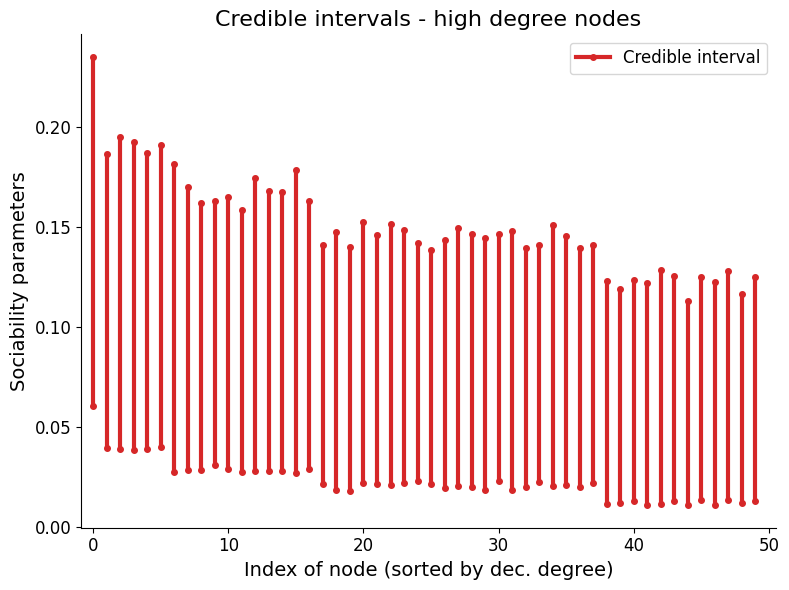

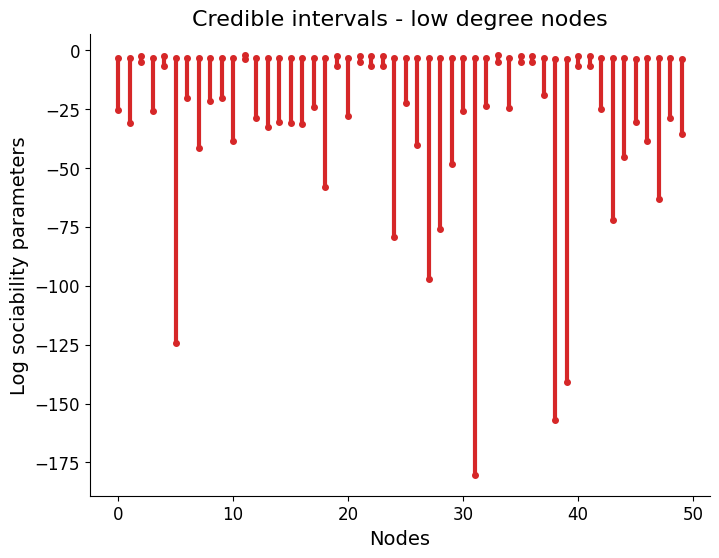

In [9]:
nburn = niter//2//thin
plot_mean_w_ci(G,objmcmc,w_true=None,nburn=nburn,dpi=100)

## Posterior predictive degree distribution

Rapid


  2%|▏         | 2/100 [00:00<00:05, 18.48it/s]

Sample 0/100 from the posterior predictive


100%|██████████| 100/100 [00:02<00:00, 39.70it/s]
/Users/vkilian/TheseShareFile/rapidly_varying_crm/code/src/display/plotposteriorpredictivedegreedistrib.py:122: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(xlim)


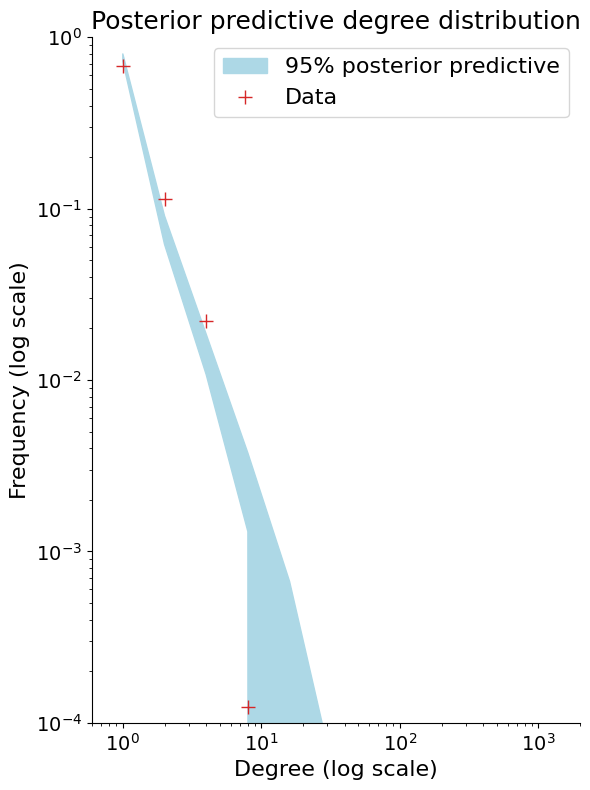

In [10]:
plot_posterior_predictive_degree(objmcmc,nburn=nburn,niter=niter,thin=thin,G=G,ndraws=100,dpi=100,ylim=(10**(-4), 1))

## Convergence diagnostic

In [11]:
#Convert to ArviZ
obmcmcarviz=to_arviz(objmcmc,nburn,thin)

#Gelman-Rubin convergence diagnostic
gr_stats = az.rhat(obmcmcarviz,method="identity")
print(gr_stats)

<xarray.Dataset> Size: 32kB
Dimensions:  (w_dim_0: 1014, s_dim_0: 1014)
Coordinates:
  * w_dim_0  (w_dim_0) int64 8kB 0 1 2 3 4 5 6 ... 1008 1009 1010 1011 1012 1013
  * s_dim_0  (s_dim_0) int64 8kB 0 1 2 3 4 5 6 ... 1008 1009 1010 1011 1012 1013
Data variables:
    w        (w_dim_0) float64 8kB 1.002 0.9996 1.006 ... 1.011 1.002 1.003
    w_rem    float64 8B 1.045
    beta     float64 8B 1.523
    c        float64 8B 1.311
    eta      float64 8B 1.559
    s        (s_dim_0) float64 8kB 1.004 0.9996 1.017 ... 1.077 1.018 1.011


In [12]:
#Multivariate GR, see Vats and Knudons, "Revisiting the Gelman-Rubin diagnostic"Statistical Science, (2021).

R=np.array(gr_stats["w"])
Rs=np.array(gr_stats["s"])
Rbeta=float(gr_stats["beta"])
Rc=float(gr_stats["c"])
Reta=float(gr_stats["eta"])
Rwrem=float(gr_stats["w_rem"])
R=np.concatenate((R,Rs,[Rbeta,Rc,Reta,Rwrem]))
#R=np.array([Rbeta,Rc,Reta,Rwrem])
p=np.shape(R)[0]
n=(niter-nburn)//thin
x=n*R**2-n+1
Rtot=np.sqrt((n-1)/n+gmean(x)/n)
print('R_multi=',Rtot)


R_multi= 1.0014160573823279
